In [1]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from cycler import cycler
import pandas as pd
import seaborn as sns

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

def svd_jacs(test_id_first, start, end, interval, seed, sigmas, m):
    jacs = {i:[] for i in range(start, end, interval)}
    us = {i:[] for i in range(start, end, interval)}
    vts = {i:[] for i in range(start, end, interval)}
    test_id = test_id_first + str(seed)
    for i in range(start, end, interval):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy')
        if sigmas:
            L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')

        u, s, vt = cal_W(mat, L, m)
        jacs[i].append(s)
        us[i].append(u)
        vts[i].append(vt)

    return jacs, us, vts

def plot_sin_cum_general(test_id_first, m = 'all', seed = 0, window=5, window2='all', start=20, end=100, interval=20, seq_len=30, sigmas=True, log_bool=False):
    singular, us, vts = svd_jacs(test_id_first, start, end, interval, seed, sigmas, m)
    gn_dic = {}
    fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=150)
    fig2, ax2 = plt.subplots(figsize=(5, 4), dpi=150)
    for i in range(start, end, interval):
        jac_arr = np.array(singular[i])
        if log_bool:
            jac_arr = np.log(jac_arr)
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean_cum = np.cumsum(jac_mean)
        jac_mean_cum /= jac_mean_cum[-1]
        gn = gini(jac_mean_cum)
        gn_dic[i] = gn
        ax1.plot(jac_mean[:window], 
                label=str(i), 
                alpha=0.5)

        if window2 == 'all':
            ax2.plot(jac_mean_cum, label=str(i), alpha=0.5)
        else:
            ax2.plot(jac_mean_cum[:window2], label=str(i), alpha=0.5)
    ax2.set_xlabel("singular value index")
    ax2.set_ylabel("singular cumsum(normalized)")
    ax2.legend(loc=[1.01,0])

    ax1.set_xlabel("singular value index")
    ax1.set_xticks(range(window), [1+i for i in range(window)])
    ax1.set_ylabel("singular value")
    ax1.legend(loc=[1.01,0])
 
    return gn_dic, singular, us, vts

def analy_u_general(us, seq_len, dims, start, end, interval, target):
    for j in target:
        for i in range(start, end, interval):
            u = np.array(us[i])
            u_col1 = u[0, :, j]
            u_col1 = u_col1.reshape(seq_len,dims)
            u_col1 = np.abs(u_col1)
            plt.figure()
            sns.heatmap(u_col1)
            plt.xlabel('space')
            plt.ylabel('time')
            plt.title(str(i)+"_index={0}".format(j))
            
def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

def cal_W(A, Sigma, m):
    n = A.shape[0]
    matrix_a = np.conj(A).T @ np.linalg.inv(Sigma) @ A
    matrix_b = np.linalg.inv(Sigma)
    block_matrix = create_block_diagonal_matrix(matrix_a, matrix_b)
    U, S, VT = np.linalg.svd(block_matrix)
    if m == "all":
        U = np.abs(U)
    else:
        U = np.abs(U)[:, :m]
        S = S[:m]
    U2 = U[:n,:] + U[n:,:]
    U2 = U2 @ np.diag(S)
    U2U, S2, V2T = np.linalg.svd(U2)
    return U2U, S2, V2T

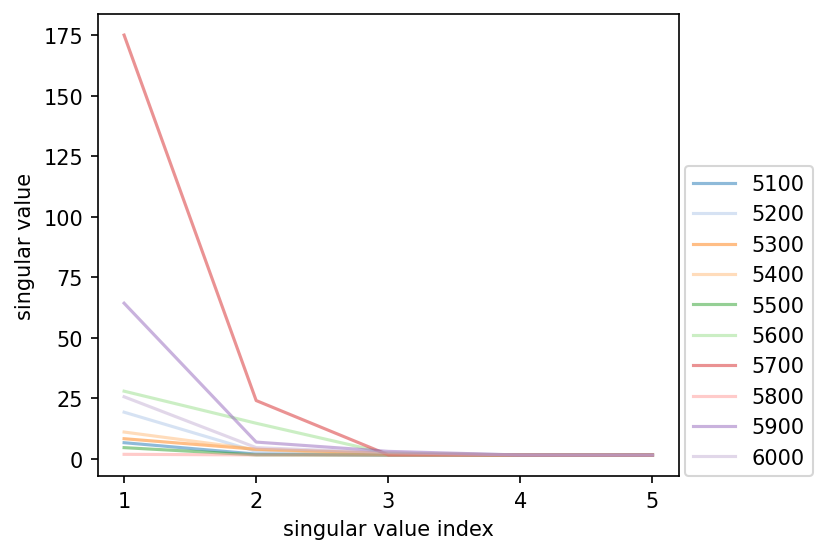

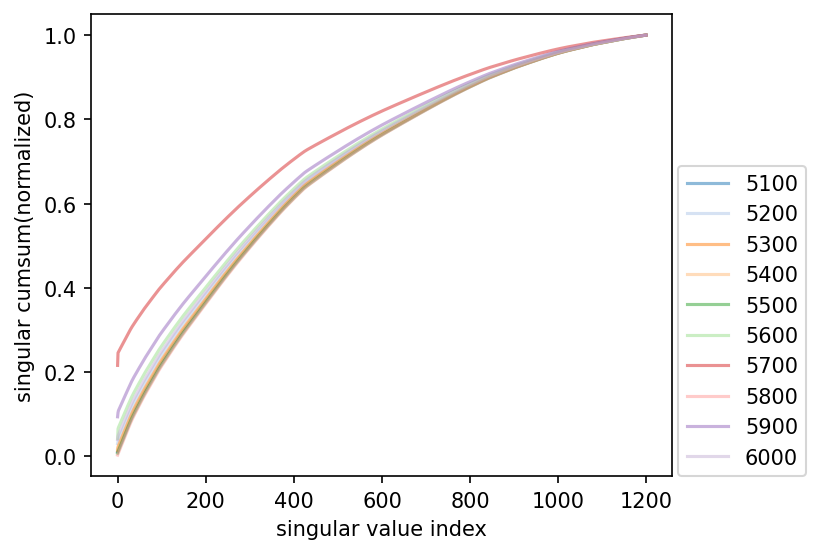

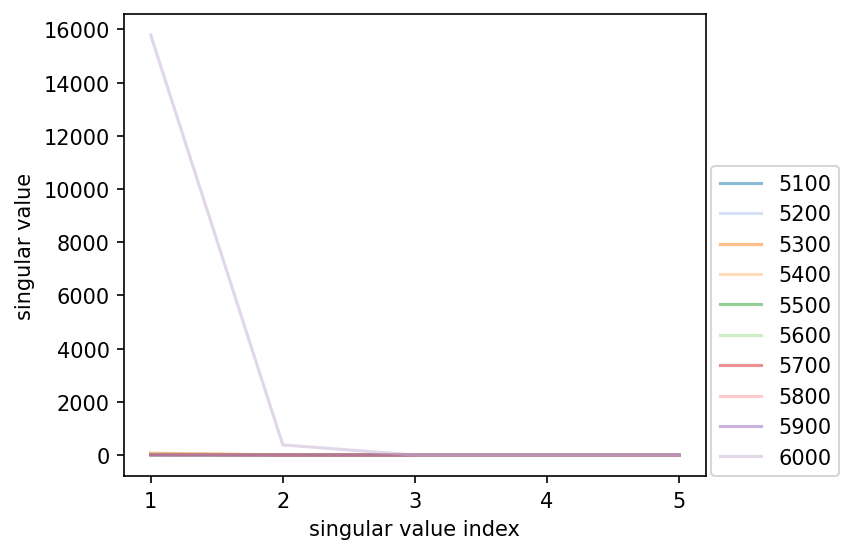

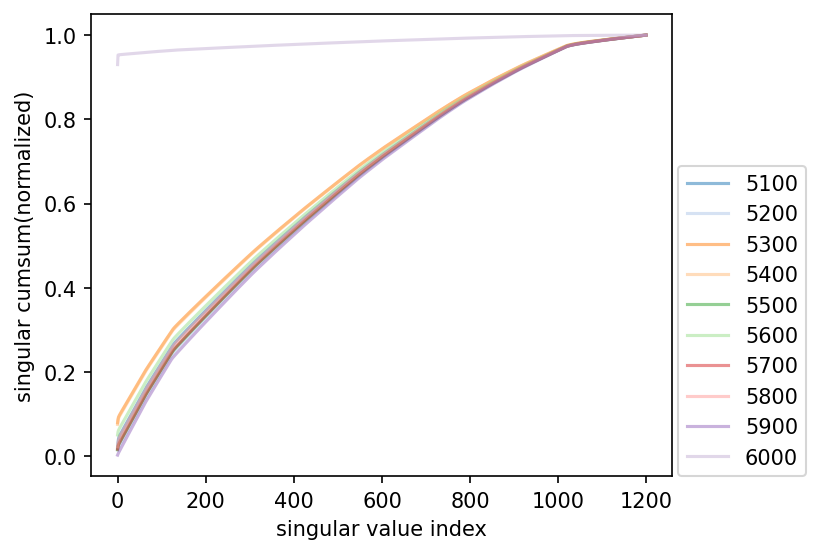

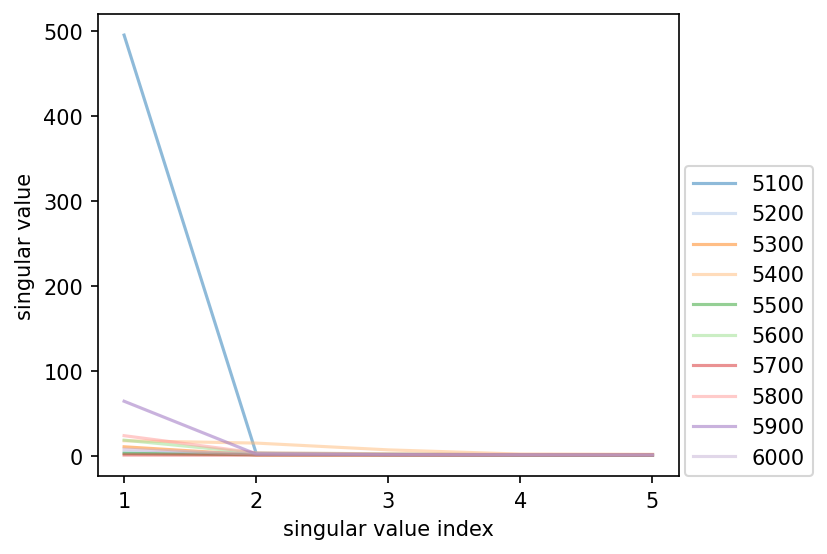

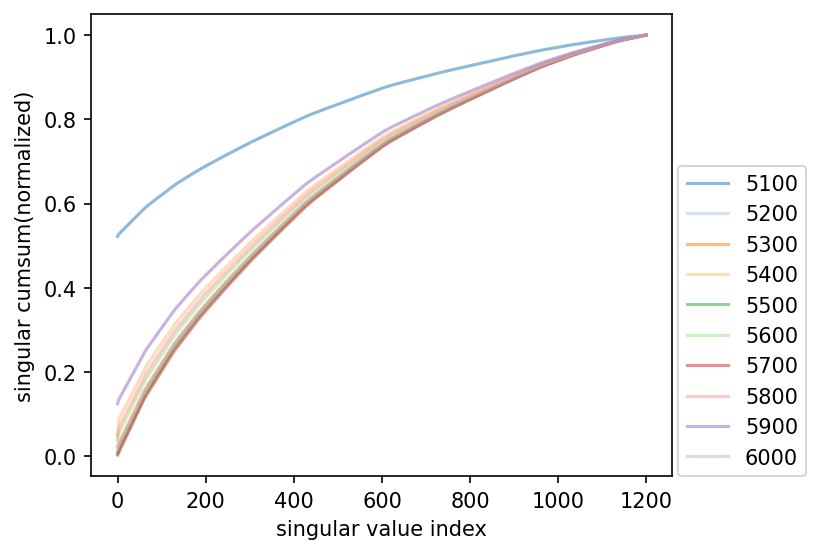

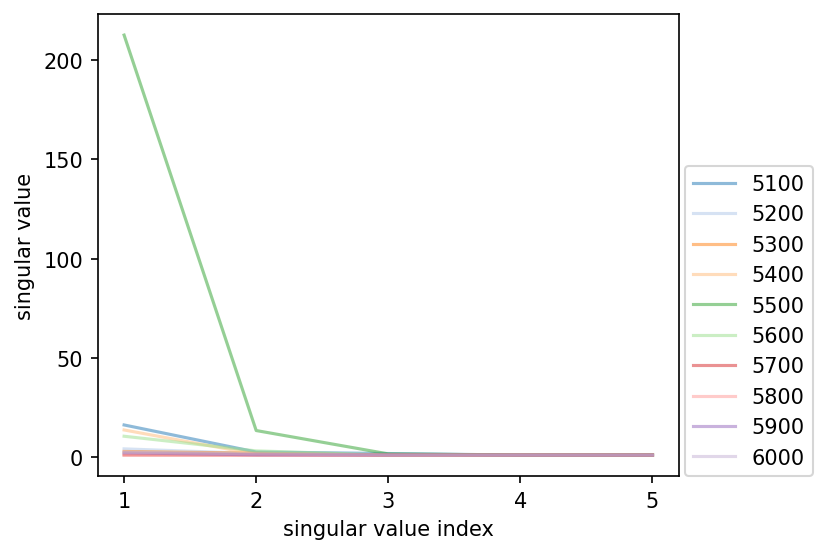

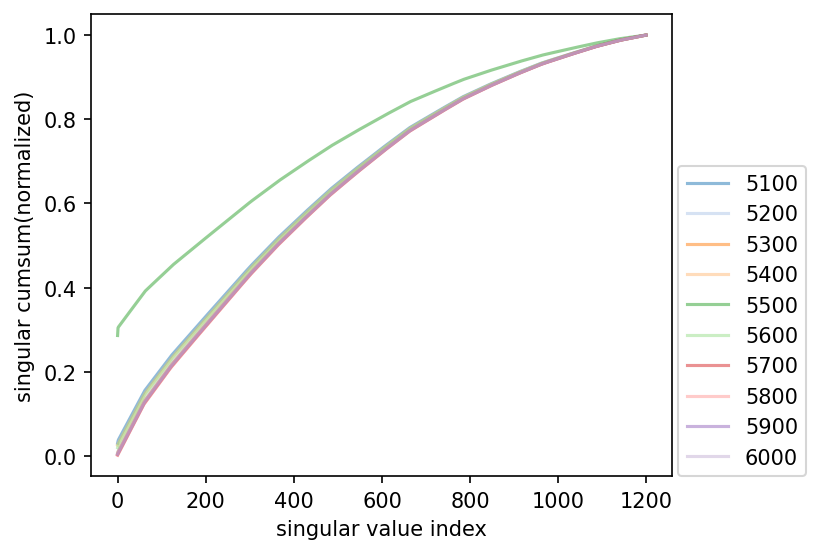

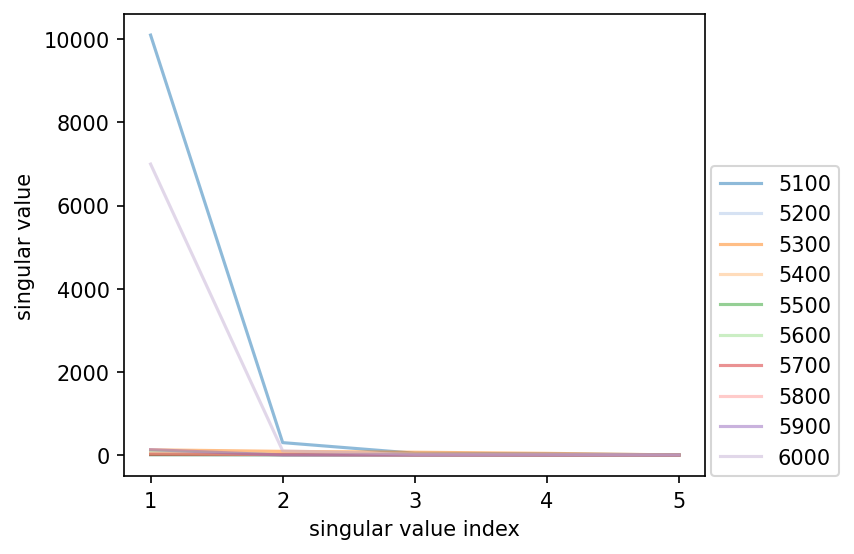

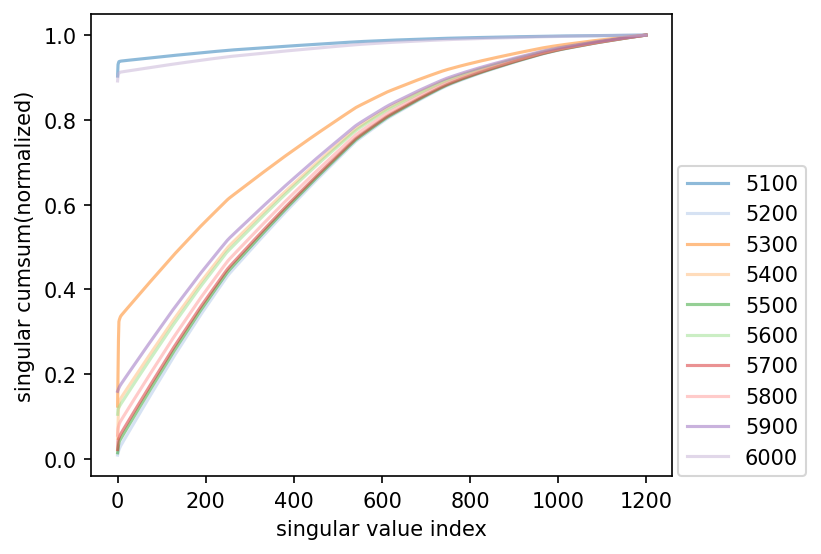

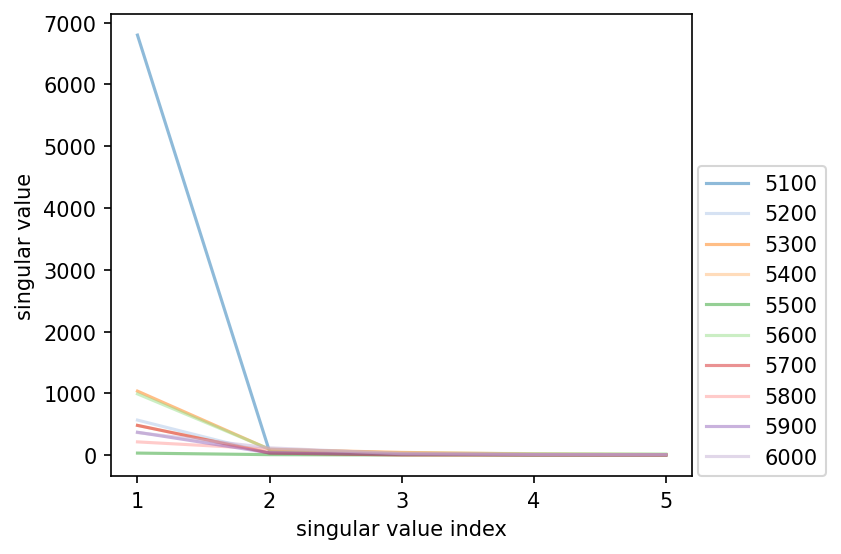

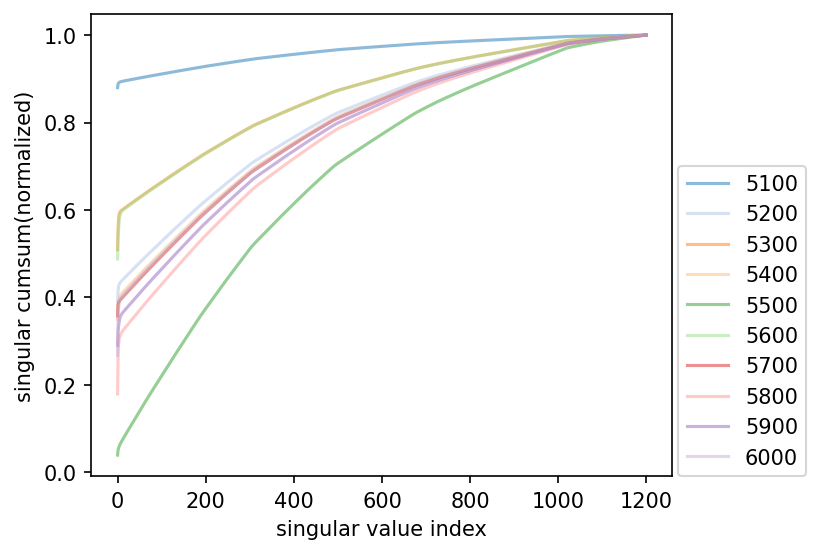

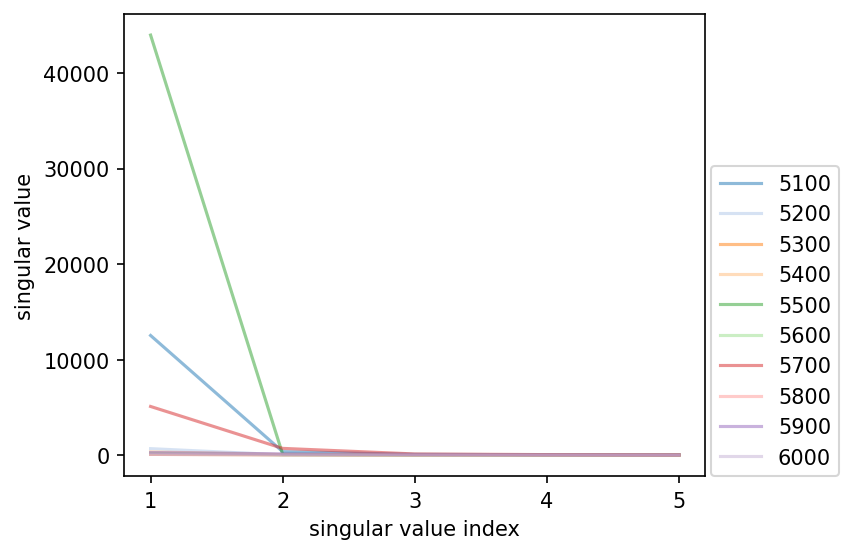

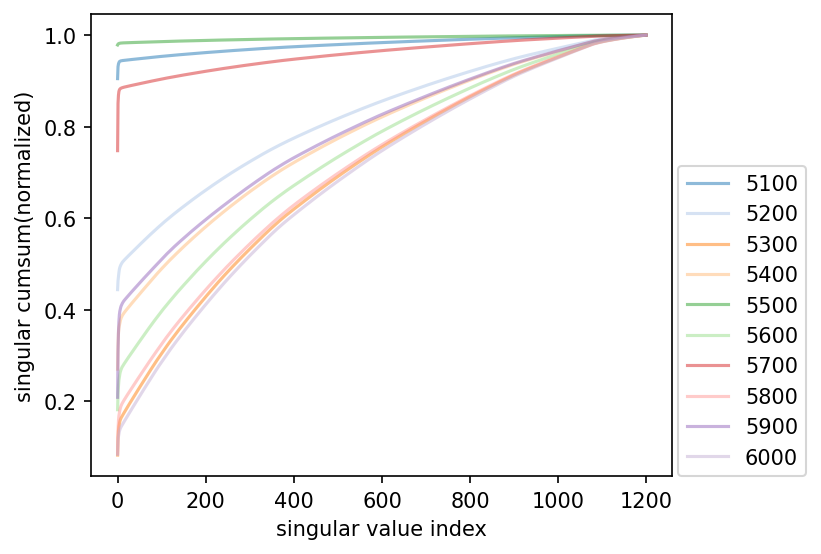

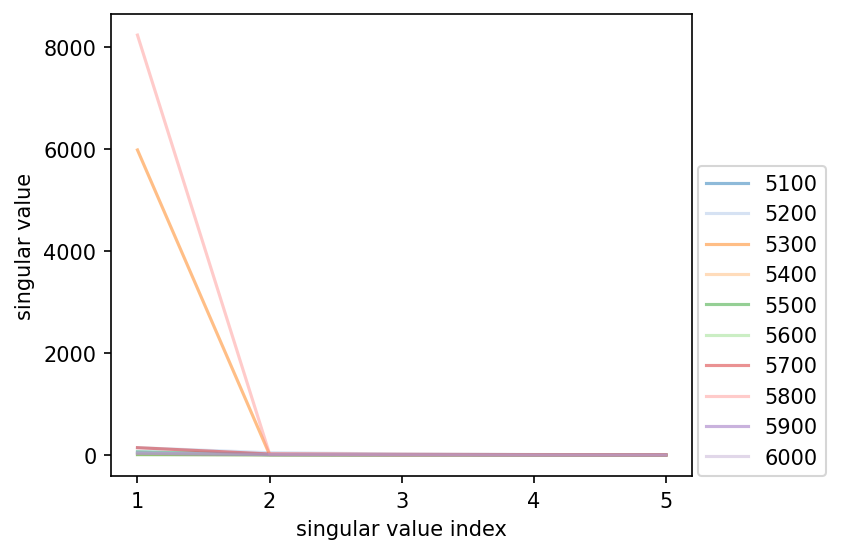

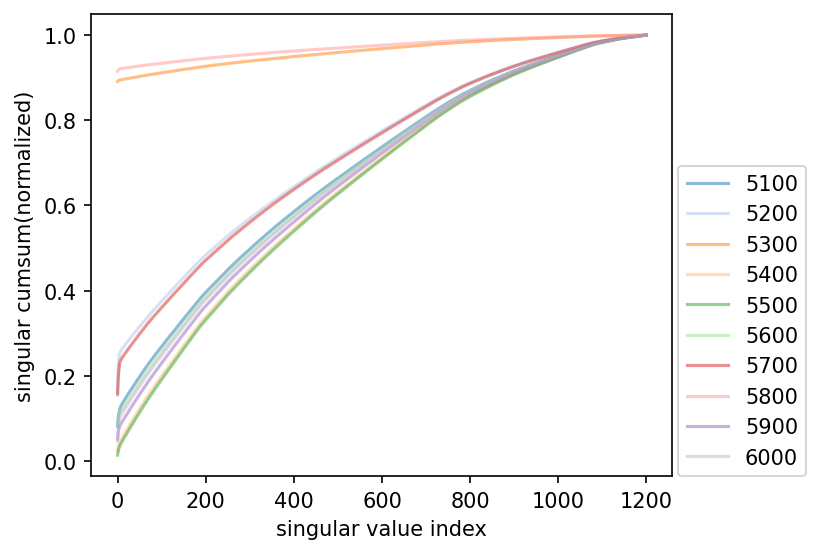

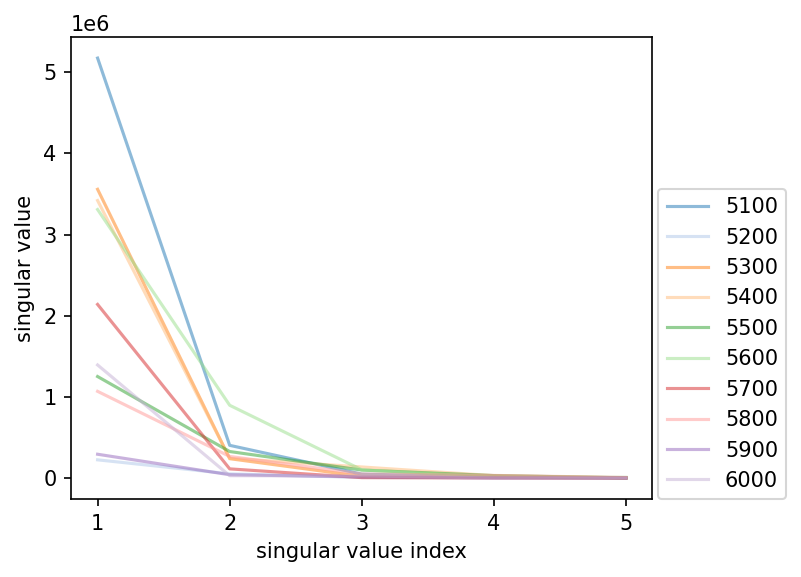

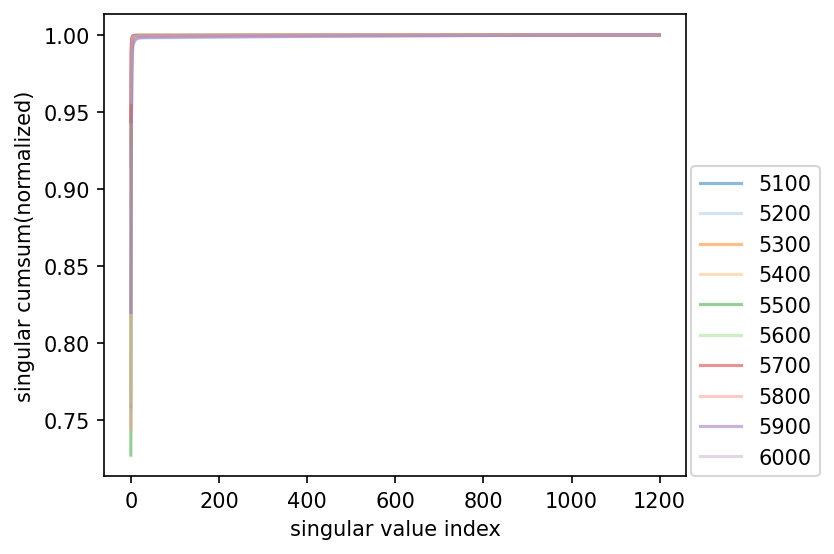

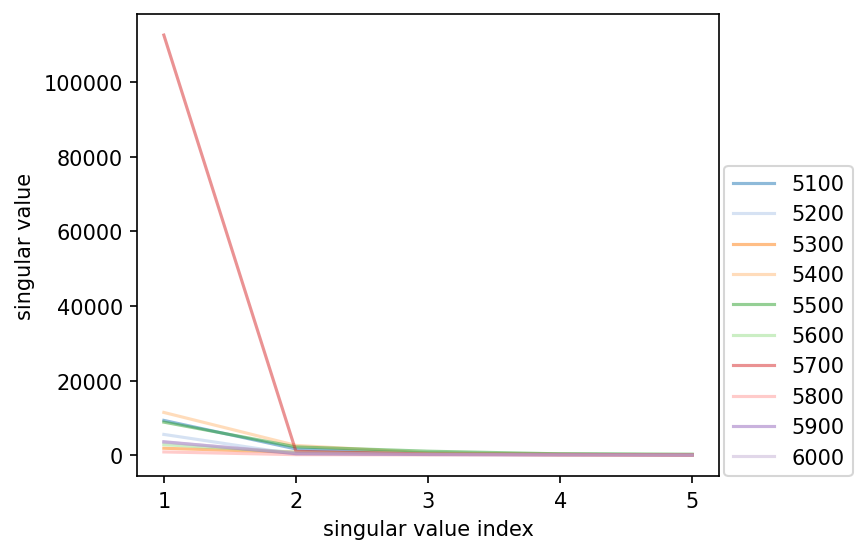

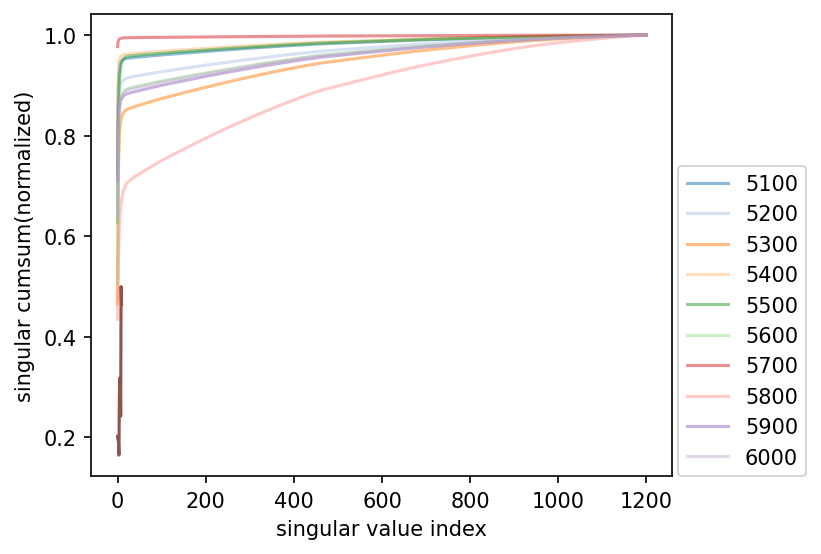

In [5]:
att_ls = [1,20,30,60,80,100,120,140,160,200]
gini_ls = []
for i in att_ls:
    test_id = 'long_term_forecast_swarm_2_{0}_30_10000_iTransformer_cov_Couzin_ft-1_sl20_pl20_dm512_nh8_el4_dl1_df512_fc3_flocnormal_lam0.001_dtTrue_Exp_'.format(i)
    gn_dic, singular, us, vts = plot_sin_cum_general(test_id, m='all', seed = 0, start=5100, end=6001, interval=100, sigmas=True, log_bool=False)
    mean_value = sum(gn_dic.values()) / len(gn_dic)
    gini_ls.append(mean_value)
plt.plot(gini_ls)

Text(0, 0.5, 'gini_mean')

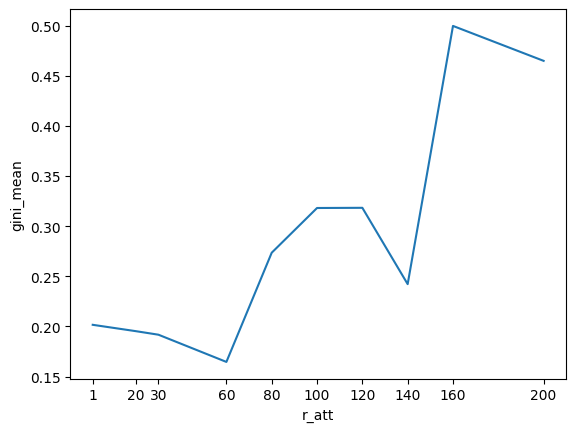

In [6]:
#att_ls = [1,20,40,60,80,100,120,140,160,180,200,220]
plt.figure()
plt.plot(att_ls, gini_ls)
plt.xticks(att_ls)
plt.xlabel('r_att')
plt.ylabel('gini_mean')

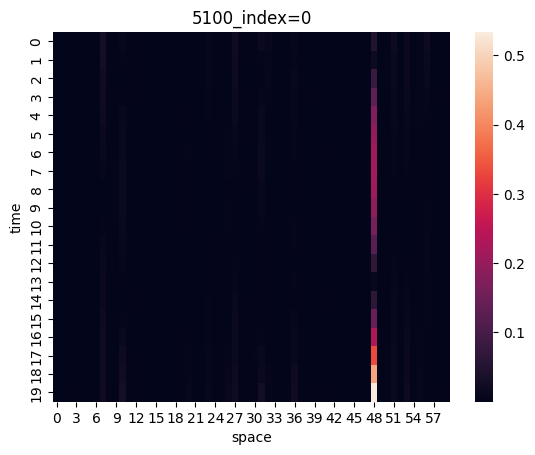

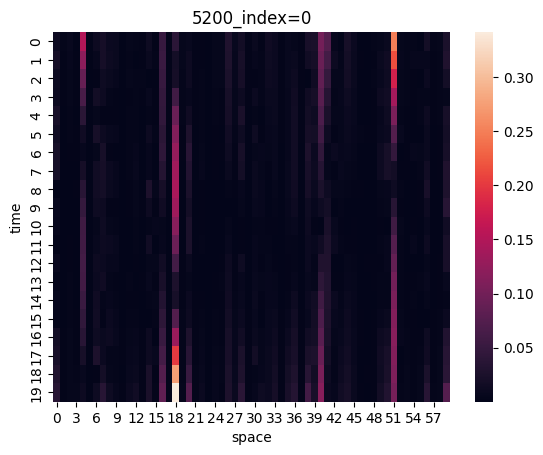

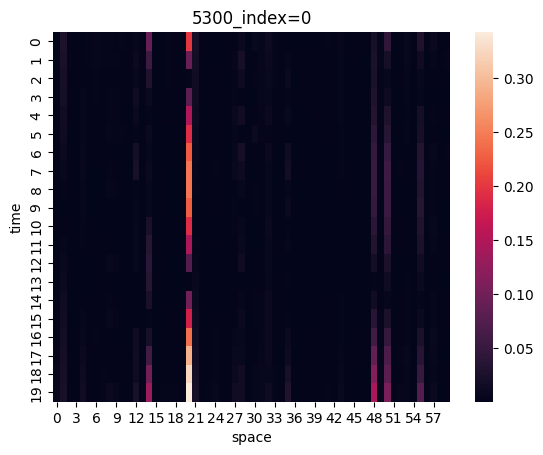

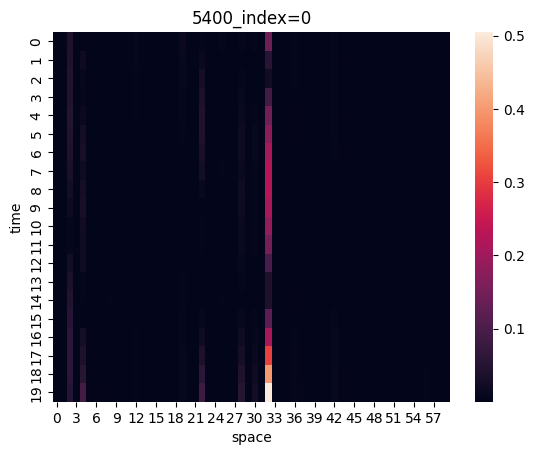

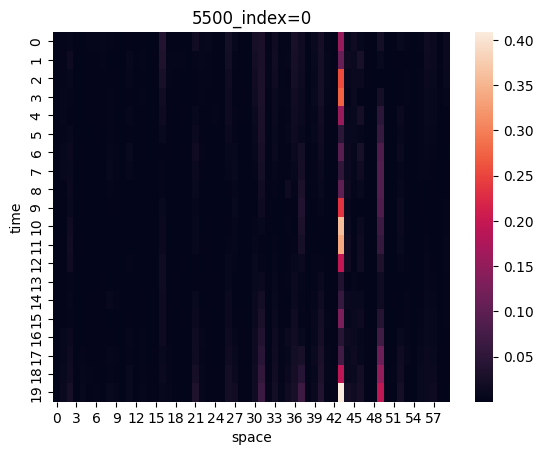

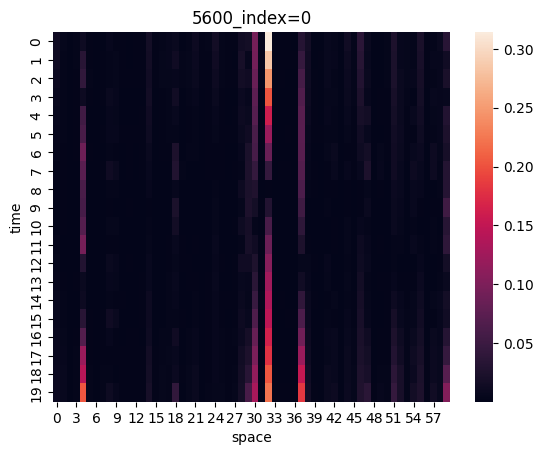

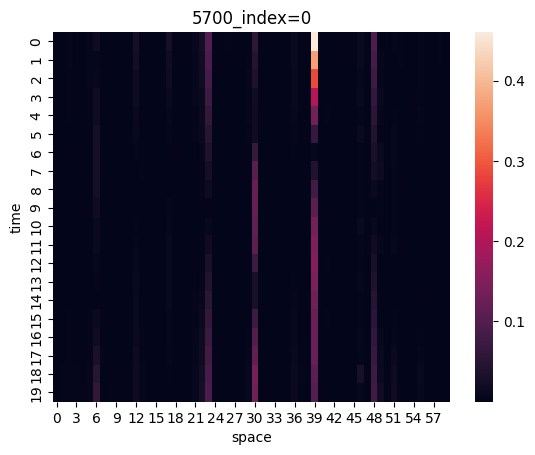

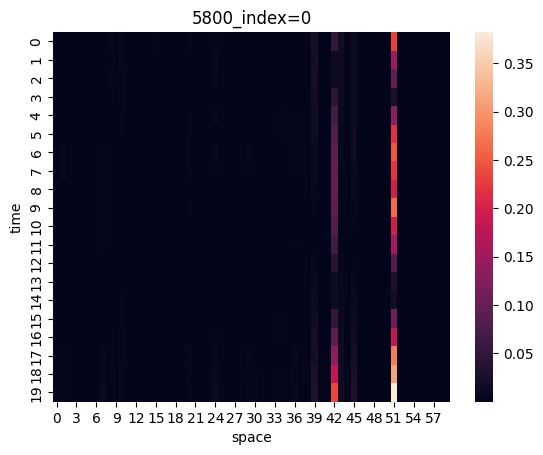

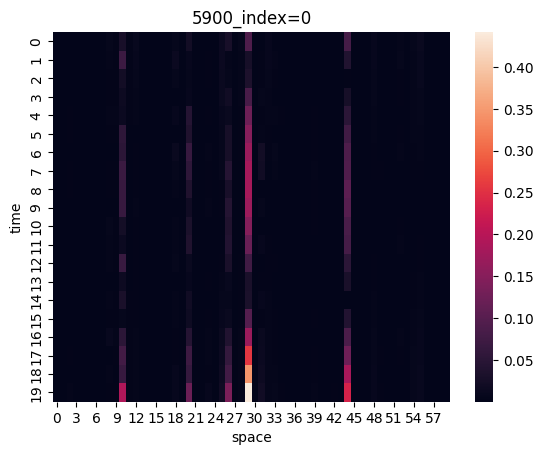

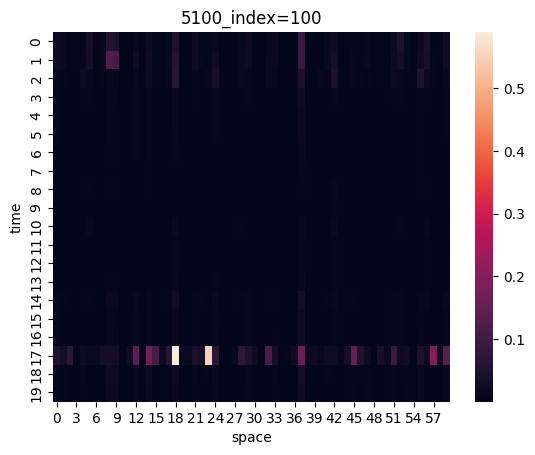

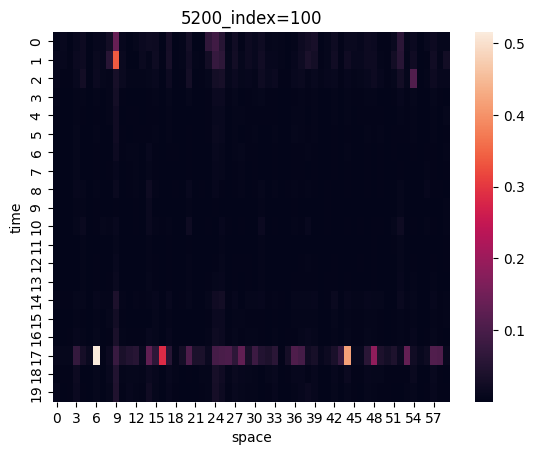

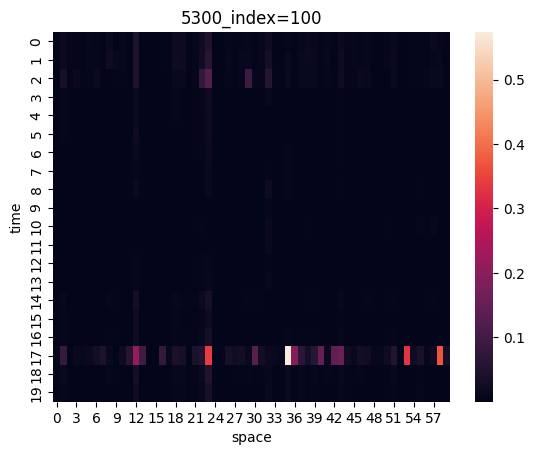

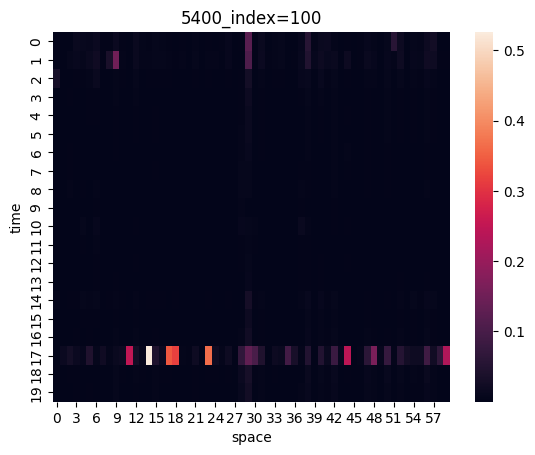

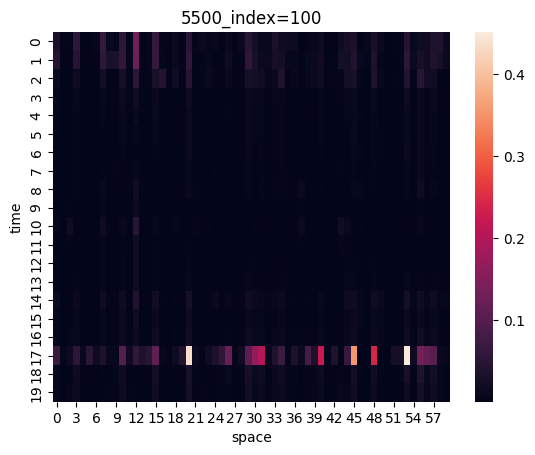

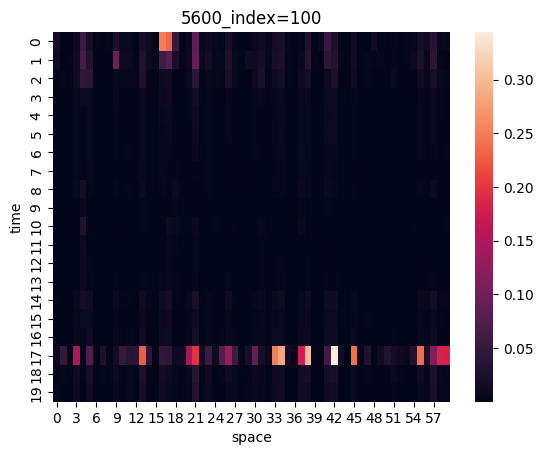

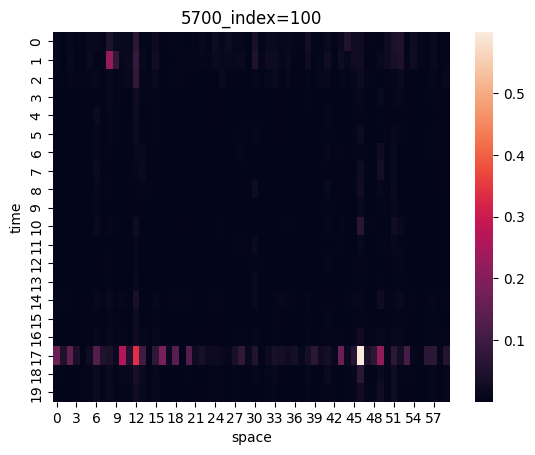

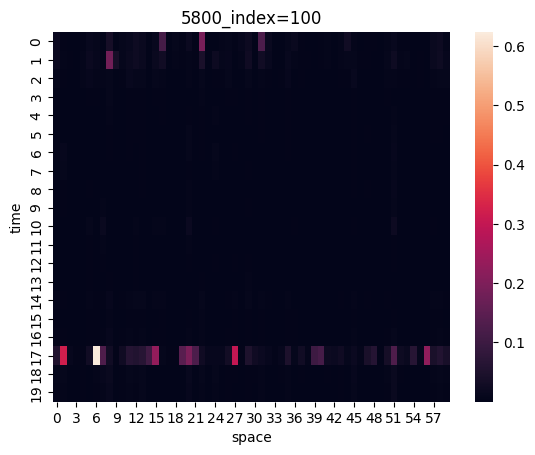

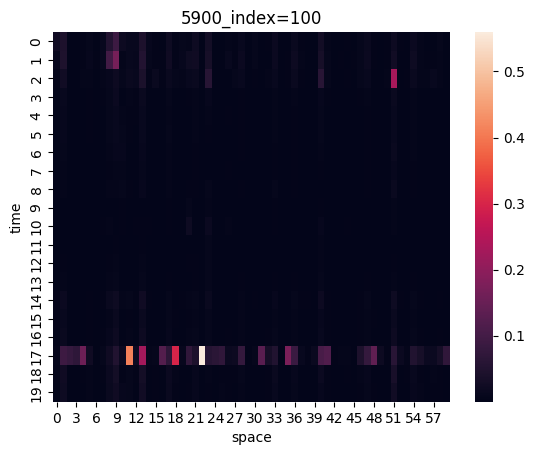

In [21]:


analy_u_general(us, seq_len=20, dims=60, start=5100, end=6000, interval=100, target=[0,100])